In [2]:
import pandas as pd
import spacy
import nltk
import re
import unidecode
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import os

In [3]:
df = pd.read_parquet(r"D:\Python for Data Analysis\alerj\leis-ordinarias\todos\leis_ordinarias.parquet")

In [4]:
#criar uma coluna data_proposicao ao reconhecer na coluna tramitacao o texto "[Data: mm/dd/yyyy]"
df['data_proposicao'] = df['tramitacao'].str.extract(r'\[Data:\s*(\d{2}/\d{2}/\d{4})\]').squeeze()
df['data_proposicao'] = pd.to_datetime(df['data_proposicao'], format='%m/%d/%Y', errors='coerce')

#criar coluna legislação
#se 2011 <= ano <= 2014 em data_proposicao -> Legislação 2011-2015
#se 2015 <= ano <= 2018 em data_proposicao -> Legislação 2015-2019
#se 2019 <= ano <= 2022 em data_proposicao -> Legislação 2019-2023
def classify_legislation(date):
    if pd.isna(date):
        return 'Desconhecido'
    year = date.year
    if 2011 <= year <= 2014:
        return 'Legislação 2011-2015'
    elif 2015 <= year <= 2018:
        return 'Legislação 2015-2019'
    elif 2019 <= year <= 2022:
        return 'Legislação 2019-2023'
    else:
        return 'Fora do intervalo'
df['legislacao'] = df['data_proposicao'].apply(classify_legislation)
df[['data_proposicao', 'legislacao']].head(10)

,data_proposicao,legislacao
0,2011-02-04,Legislação 2011-2015
1,2011-02-04,Legislação 2011-2015
2,2011-02-04,Legislação 2011-2015
3,2011-02-04,Legislação 2011-2015
4,2011-02-04,Legislação 2011-2015
5,2011-02-04,Legislação 2011-2015
6,2011-02-04,Legislação 2011-2015
7,2011-02-04,Legislação 2011-2015
8,2011-02-04,Legislação 2011-2015
9,2011-02-04,Legislação 2011-2015


TOTAL DE PROJETOS ANALISADOS: 14,416
PROJETOS SOBRE CRIME ORGANIZADO: 172 (1.19%)
PROJETOS SOBRE OUTROS TEMAS: 14,244 (98.81%)

DISTRIBUIÇÃO POR CATEGORIA (projetos podem estar em mais de uma):

 atividades_crime_org            114 projetos ( 66.3%)
 termos_legais_genericos          58 projetos ( 33.7%)
 faccoes_especificas              11 projetos (  6.4%)
 violencia_associada              10 projetos (  5.8%)
 milicia_paramilitar               7 projetos (  4.1%)
 conceitos_territoriais            2 projetos (  1.2%)
ANÁLISE POR AUTOR

TOP 15 AUTORES COM MAIS PROJETOS SOBRE O TEMA:

    1. Rodrigo Amorim                       11 projetos
    2. Dionisio Lins                         8 projetos
    3. Rosenverg Reis                        8 projetos
    4. Zaqueu Teixeira                       7 projetos
    5. Alana Passos                          5 projetos
    6. Paulo Ramos                           5 projetos
    7. Martha Rocha                          5 projetos
    8. Danniel L

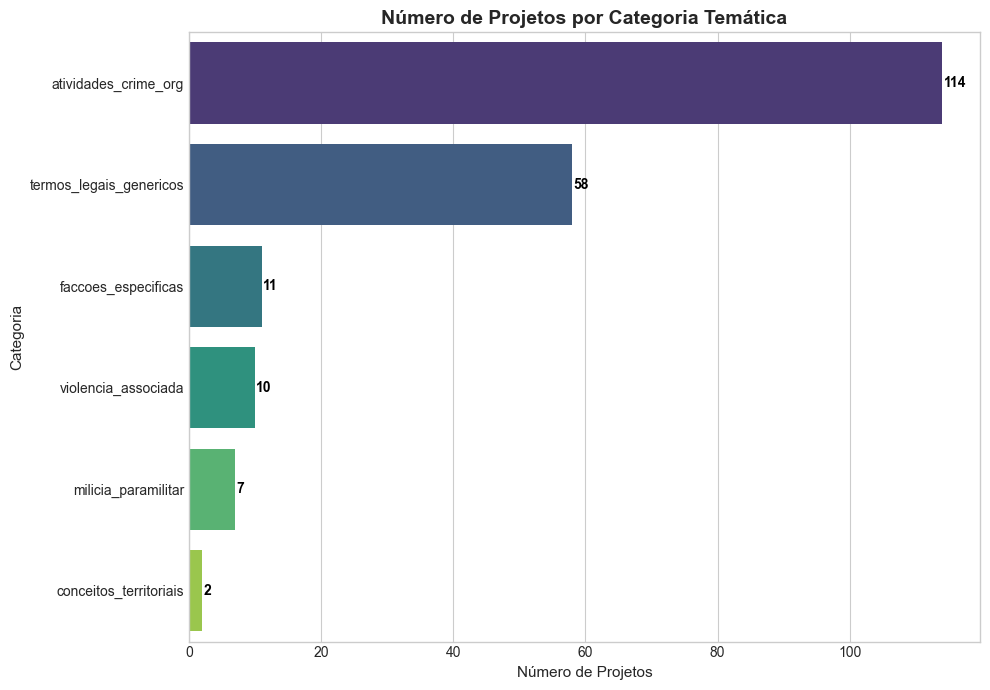

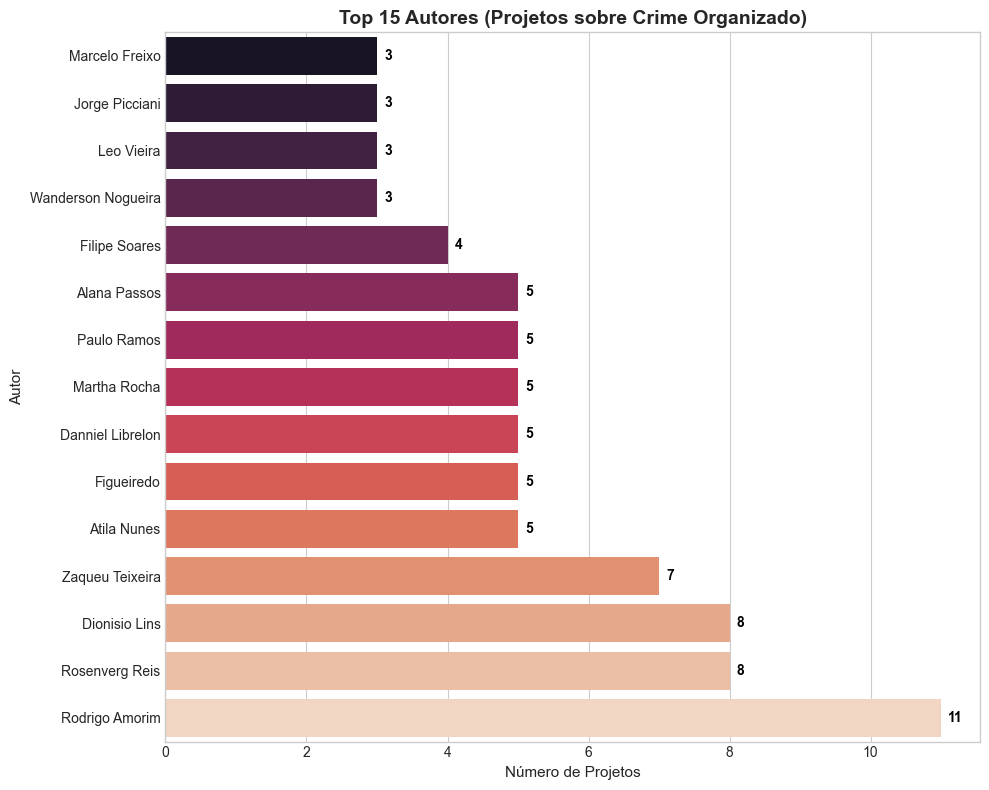

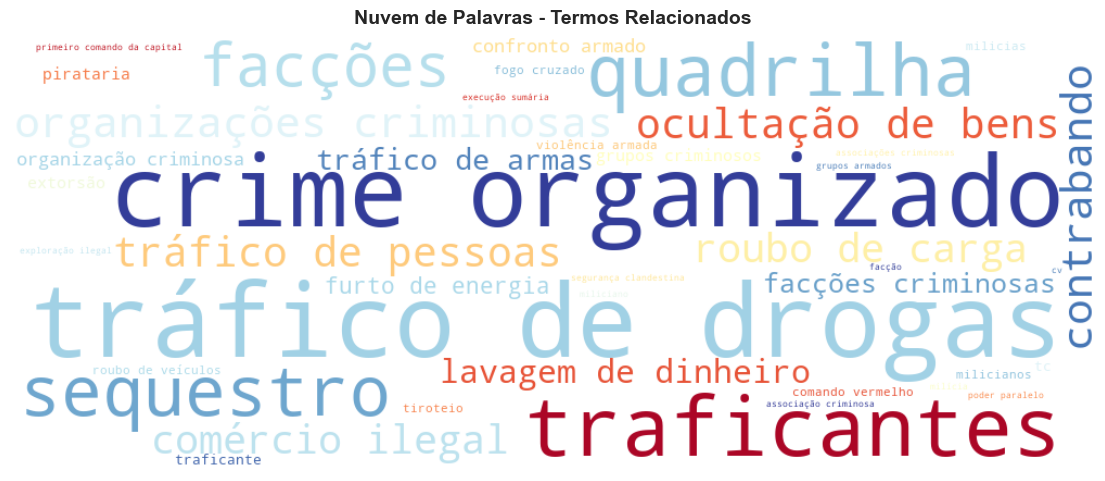

In [6]:
#citacoes especificas sobre crime organizado
from collections import defaultdict, Counter
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# 1. DICIONÁRIO TEMÁTICO (CRIME ORGANIZADO)

DICIONARIO_CRIME_ORGANIZADO = {
    'faccoes_especificas': [
        # Facções mais conhecidas do RJ e variações de escrita
        'comando vermelho', 'cv', 'terceiro comando puro', 'tcp', 
        'terceiro comando', 'tc', 'amigos dos amigos', 'ada',
        'primeiro comando da capital', 'pcc', 
        'os amigos dos amigos', 'facção comando vermelho',
        'facção terceiro comando puro', 'facção pcc', 'facção ada',
        # Variações possíveis de digitação e siglas
        'facção cv', 'facção tcp', 'facção tc', 'facção amigos dos amigos',
        'facções criminosas', 'facção criminosa'
    ],

    'milicia_paramilitar': [
        'milícia', 'milicias', 'miliciano', 'milicianos',
        'milícia armada', 'milícia privada', 'grupo paramilitar', 
        'grupos paramilitares', 'organização paramilitar',
        'organizações paramilitares', 'grupo parapolicial', 'grupos parapoliciais',
        'grupo armado ilegal', 'grupos armados ilegais',
        'autodefesa armada', 'segurança clandestina',
        'milícia urbana', 'milícia rural', 'controle por milicianos',
        'domínio por milícia', 'expansão miliciana'
    ],

    'termos_legais_genericos': [
        'organização criminosa', 'organizações criminosas', 'crime organizado', 
        'crimes organizados', 'associação criminosa', 'associações criminosas',
        'facção', 'facções', 'facção criminosa', 'facções criminosas',
        'entidade criminosa', 'estrutura criminosa', 'rede criminosa',
        'grupo criminoso', 'grupos criminosos', 'grupo de crime organizado',
        'quadrilha', 'bando armado', 'organização ilícita', 
        'associação para o crime', 'organização delituosa', 
        'sociedade criminosa', 'rede delinquente'
    ],

    'atividades_crime_org': [
        'tráfico de drogas', 'tráfico de armas', 'tráfico de pessoas',
        'lavagem de dinheiro', 'ocultação de bens', 'chefes do tráfico', 
        'narcotraficante', 'narcotraficantes', 'traficante', 'traficantes',
        'comércio ilegal', 'contrabando', 'extorsão', 'sequestro', 
        'roubo de carga', 'roubo de veículos', 'furto de energia', 
        'gatonet', 'pirataria', 'agiotagem', 'exploração ilegal',
        'jogo do bicho', 'exploração do jogo do bicho', 'corrupção policial',
        'corrupção de agentes públicos', 'corrupção de servidores',
        'crime financeiro', 'financiamento de atividades criminosas',
        'exploração de transporte alternativo ilegal'
    ],

    'conceitos_territoriais': [
        'controle territorial', 'domínio de comunidade', 'domínio armado', 
        'grupos armados', 'território sob influência', 'infiltração no estado', 
        'poder paralelo', 'bandidos armados', 'comunidades dominadas',
        'controle de território', 'influência em comunidades', 
        'ocupação de territórios', 'controle de áreas urbanas', 
        'controle de favelas', 'domínio de áreas públicas', 'territórios dominados',
        'exercício de poder paralelo', 'comunidades sob controle',
        'presença de facções em comunidades', 'domínio de territórios',
        'controle social armado', 'poder de facção em território',
        'infiltração institucional', 'captura do estado',
        'cooptação de agentes públicos', 'controle comunitário armado'
    ],

    'institucional_politico': [
        'infiltração na política', 'financiamento eleitoral ilícito',
        'influência política de facções', 'participação de milicianos em eleições',
        'aliança com agentes públicos', 'corrupção institucionalizada',
        'infiltração em órgãos públicos', 'influência em segurança pública',
        'penetração em forças policiais', 'cooptação institucional',
        'proteção estatal a milicianos', 'colaboração com grupos criminosos'
    ],

    'violencia_associada': [
        'execução sumária', 'intimidação armada', 'ameaça a moradores',
        'ameaça a agentes públicos', 'violência armada', 'confronto armado',
        'guerra entre facções', 'disputa territorial', 'tiroteio', 'fogo cruzado',
        'ataque criminoso', 'ataque de facção', 'ataque de milicianos',
        'ação criminosa organizada', 'ação coordenada de facção',
        'intervenção policial em áreas dominadas'
    ],

    'contexto_social': [
        'comunidade sob domínio', 'favela controlada', 'controle paralelo',
        'imposição de regras', 'justiça paralela', 'imposição de toque de recolher',
        'controle social armado', 'poder paralelo nas comunidades',
        'influência de facção em comunidade', 'proibição imposta por facção',
        'administração territorial ilícita'
    ]
}

# Compilar todas as palavras-chave para estatísticas
TODAS_PALAVRAS_CHAVE = [termo for sublist in DICIONARIO_CRIME_ORGANIZADO.values() for termo in sublist]

# 2. FUNÇÕES DE PROCESSAMENTO

def normalizar_texto(texto):
    """Normaliza o texto: minúsculas e remove acentos."""
    if pd.isna(texto): return ""
    texto = texto.lower()
    substituicoes = {
        'á': 'a', 'à': 'a', 'ã': 'a', 'â': 'a', 'ä': 'a',
        'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
        'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
        'ó': 'o', 'ò': 'o', 'õ': 'o', 'ô': 'o', 'ö': 'o',
        'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
        'ç': 'c', 'ñ': 'n'
    }
    for original, substituto in substituicoes.items():
        texto = texto.replace(original, substituto)
    return texto

def pre_normalizar_dicionario(dicionario):
    """Cria padrões regex para cada termo, otimizando a busca."""
    dicionario_norm = defaultdict(list)
    for categoria, palavras in dicionario.items():
        for palavra in palavras:
            palavra_norm = normalizar_texto(palavra)
            # Cria um padrão regex. \b garante que 'cv' não pegue 'curriculo vitae'
            # Mas para frases, não usamos \b
            if len(palavra_norm.split()) == 1:
                pattern = r'\b' + re.escape(palavra_norm) + r'\b'
            else:
                pattern = re.escape(palavra_norm)
            # Armazena (palavra_original, padrão_regex_compilado)
            dicionario_norm[categoria].append((palavra, re.compile(pattern)))
    return dict(dicionario_norm)

def analisar_projeto_crime_org(texto_norm, dicionario_compilado):
    """
    Analisa o texto e retorna se é relevante, as categorias e palavras encontradas.
    """
    if not texto_norm:
        return False, set(), []

    categorias_encontradas = set()
    palavras_encontradas = []

    for categoria, termos in dicionario_compilado.items():
        for palavra_original, pattern in termos:
            if pattern.search(texto_norm):
                categorias_encontradas.add(categoria)
                palavras_encontradas.append(palavra_original)
    
    encontrou = len(palavras_encontradas) > 0
    # Retorna as palavras originais, sem duplicatas
    return encontrou, categorias_encontradas, list(set(palavras_encontradas))

# 3. ANÁLISE PRINCIPAL

# Pré-compilar o dicionário para eficiência
DICIONARIO_COMPILADO = pre_normalizar_dicionario(DICIONARIO_CRIME_ORGANIZADO)

df['texto_norm'] = df['texto_do_projeto'].apply(normalizar_texto)

# Aplicar a função de análise
resultados = df['texto_norm'].apply(
    lambda x: analisar_projeto_crime_org(x, DICIONARIO_COMPILADO)
)
df['relevante_crime_org'], df['categorias_crime_org'], df['palavras_crime_org'] = zip(*resultados)

df_relevantes = df[df['relevante_crime_org']].copy()

# 4. RESULTADOS NO CONSOLE

total_pls = len(df)
pls_relevantes = len(df_relevantes)
percentual = 0
if total_pls > 0:
    percentual = (pls_relevantes / total_pls) * 100

print(f"TOTAL DE PROJETOS ANALISADOS: {total_pls:,}")
print(f"PROJETOS SOBRE CRIME ORGANIZADO: {pls_relevantes:,} ({percentual:.2f}%)")
print(f"PROJETOS SOBRE OUTROS TEMAS: {total_pls - pls_relevantes:,} ({100-percentual:.2f}%)")

# Análise por Categoria

categorias_count = defaultdict(int)
for categorias_set in df_relevantes['categorias_crime_org']:
    for categoria in categorias_set:
        categorias_count[categoria] += 1

categorias_ordenadas = sorted(categorias_count.items(), key=lambda x: x[1], reverse=True)
df_categorias = pd.DataFrame(categorias_ordenadas, columns=['categoria', 'contagem'])

print("\nDISTRIBUIÇÃO POR CATEGORIA (projetos podem estar em mais de uma):\n")
for _, row in df_categorias.iterrows():
    perc_cat = (row['contagem'] / pls_relevantes) * 100
    print(f" {row['categoria']:30s} {row['contagem']:4d} projetos ({perc_cat:5.1f}%)")

#Análise por Autor

print("ANÁLISE POR AUTOR")

# Limpar e explodir a coluna de autores
autores_list = []
if not df_relevantes.empty:
    df_autores = df_relevantes[['autores']].copy()
    # Separa por vírgula, ' e ', ou ponto e vírgula
    df_autores['autores'] = df_autores['autores'].str.split(r',| e |;')
    df_autores = df_autores.explode('autores')
    
    # Limpa nomes (remove "Deputado ", "Deputada " e espaços extras)
    df_autores['autor_limpo'] = df_autores['autores'].str.replace(
        r'^(deputado|deputada)\s+', '', flags=re.IGNORECASE, regex=True
    ).str.strip()
    
    # Remove entradas vazias que podem surgir do split
    df_autores = df_autores[df_autores['autor_limpo'] != '']
    
    autores_count = df_autores['autor_limpo'].value_counts()
    
    print("\nTOP 15 AUTORES COM MAIS PROJETOS SOBRE O TEMA:\n")
    for i, (autor, freq) in enumerate(autores_count.head(15).items(), 1):
        print(f"   {i:2d}. {autor:35s} {freq:3d} projetos")
else:
    print("\nNenhum projeto relevante encontrado para analisar autores.")
    autores_count = pd.Series() # Cria uma série vazia para o gráfico não quebrar

#Análise de Termos

print("TERMOS MAIS FREQUENTES (CRIME ORGANIZADO)")

todos_termos = []
for palavras_lista in df_relevantes['palavras_crime_org']:
    todos_termos.extend(palavras_lista)

freq_termos = Counter(todos_termos)
top_20_termos = freq_termos.most_common(20)

print("\nTOP 20 TERMOS ENCONTRADOS:\n")
for i, (termo, freq) in enumerate(top_20_termos, 1):
    print(f" {i:2d}. {termo:35s} {freq:4d} ocorrências")

# 5. VISUALIZAÇÕES INDIVIDUAIS (Matplotlib)

if pls_relevantes > 0:
    
    # Gráfico 1: Barras por Categoria
    plt.figure(figsize=(10, 7))
    sns.barplot(data=df_categorias, x='contagem', y='categoria', palette='viridis')
    plt.title('Número de Projetos por Categoria Temática', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Projetos', fontsize=11)
    plt.ylabel('Categoria', fontsize=11)
    # Adicionar contagem no final da barra
    for i, v in enumerate(df_categorias['contagem']):
        plt.text(v + 0.2, i, str(v), color='black', va='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Barras por Autor (Top 15)
    if not autores_count.empty:
        plt.figure(figsize=(10, 8))
        top_15_autores = autores_count.head(15).sort_values(ascending=True)
        sns.barplot(x=top_15_autores.values, y=top_15_autores.index, palette='rocket')
        plt.title('Top 15 Autores (Projetos sobre Crime Organizado)', fontsize=14, fontweight='bold')
        plt.xlabel('Número de Projetos', fontsize=11)
        plt.ylabel('Autor', fontsize=11)
        # Adicionar contagem no final da barra
        for i, v in enumerate(top_15_autores.values):
            plt.text(v + 0.1, i, str(v), color='black', va='center', fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Gráfico de Autores pulado (nenhum autor encontrado).")

    # Gráfico 3: Nuvem de Palavras
    if freq_termos:
        plt.figure(figsize=(14, 7))
        wordcloud = WordCloud(
            width=1000, 
            height=400,
            background_color='white',
            colormap='RdYlBu_r', # Um colormap mais "sério"
            max_words=75,
            relative_scaling=0.5
        ).generate_from_frequencies(freq_termos)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nuvem de Palavras - Termos Relacionados', 
                  fontsize=14, fontweight='bold', pad=10)
        plt.show()
    else:
        print("Gráfico de Nuvem de Palavras pulado (nenhum termo encontrado).")

else:
    print("\nNenhum projeto relevante sobre Crime Organizado foi encontrado.")
    print("Nenhum gráfico será gerado.") 